In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True,
)
print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.FGWNRP_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings 

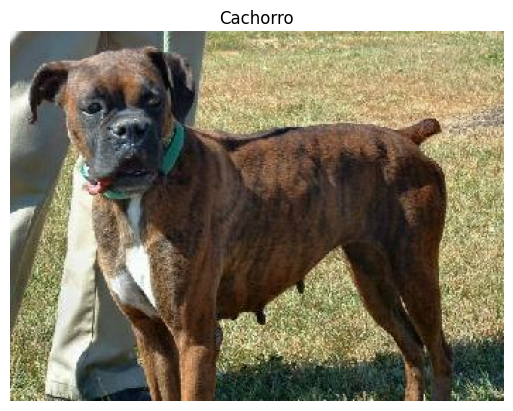

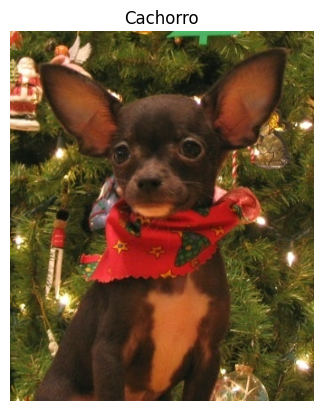

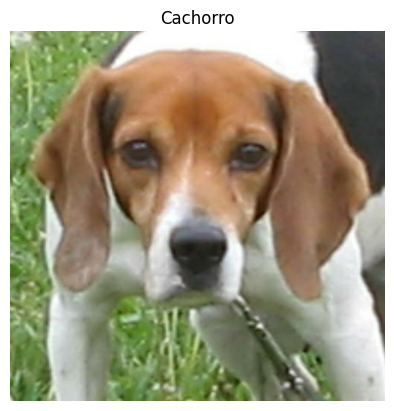

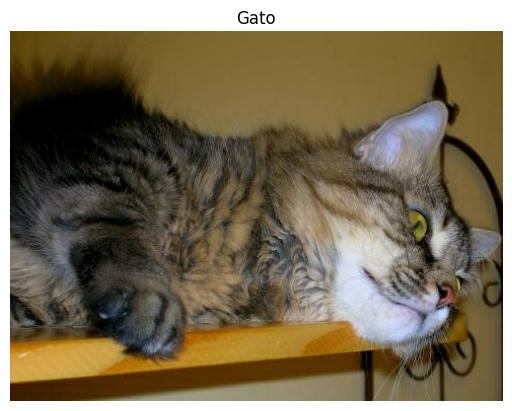

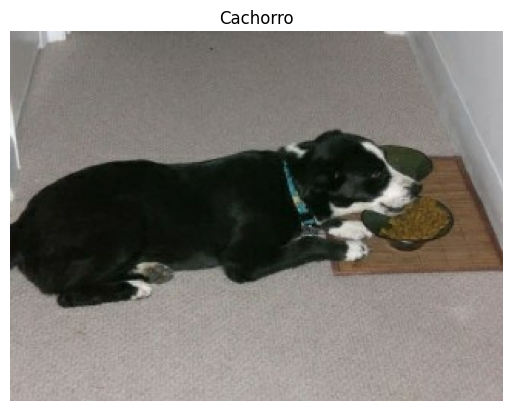

In [3]:
for image, label in ds_train.take(5):
    plt.imshow(image)
    plt.title('Gato' if label.numpy() == 0 else 'Cachorro')
    plt.axis('off')
    plt.show()

In [4]:
IMG_SIZE = 224

def format_img(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train_prepared = ds_train.map(format_img).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test_prepared = ds_test.map(format_img).batch(32).prefetch(tf.data.AUTOTUNE)

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Congela os pesos do modelo base

# Adiciona camadas finais (head) para classificar gatos e cachorros
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 1 unidade para classificação binária
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
history = model.fit(
    ds_train_prepared,
    epochs=5,                # Você pode aumentar depois!
    validation_data=ds_test_prepared
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1032s 2s/step - accuracy: 0.9580 - loss: 0.1251 - val_accuracy: 0.9839 - val_loss: 0.0445
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.9836 - loss: 0.0440 - val_accuracy: 0.9850 - val_loss: 0.0418
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1041s 2s/step - accuracy: 0.9855 - loss: 0.0388 - val_accuracy: 0.9847 - val_loss: 0.0415
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1013s 2s/step - accuracy: 0.9873 - loss: 0.0354 - val_accuracy: 0.9850 - val_loss: 0.0417
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 1066s 2s/step - accuracy: 0.9891 - loss: 0.0328 - val_accuracy: 0.9847 - val_loss: 0.0422


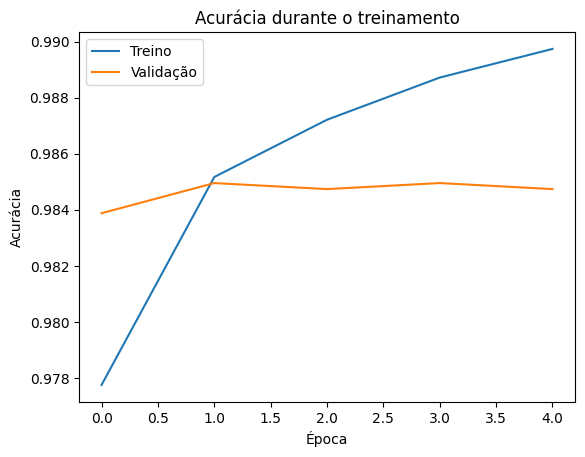

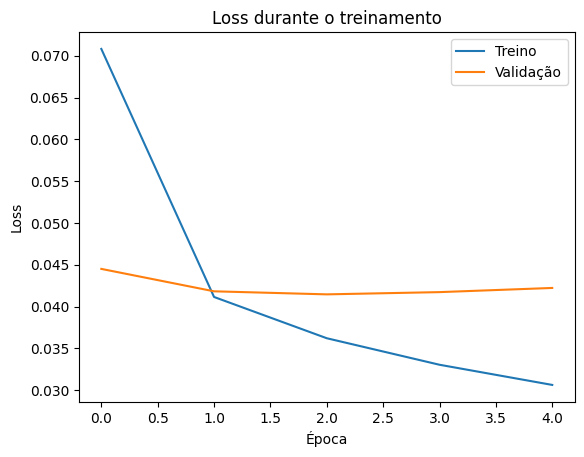

In [7]:
import matplotlib.pyplot as plt

# Gráfico de acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Gráfico de Loss
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


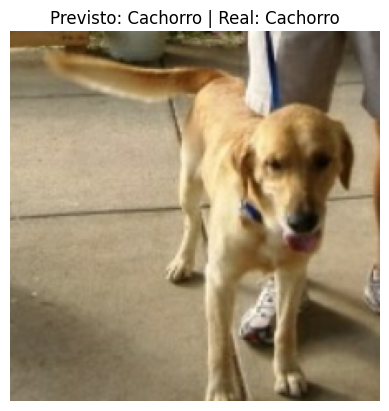

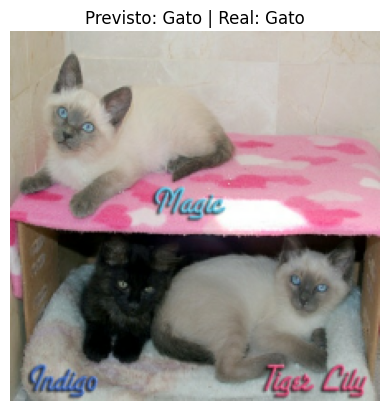

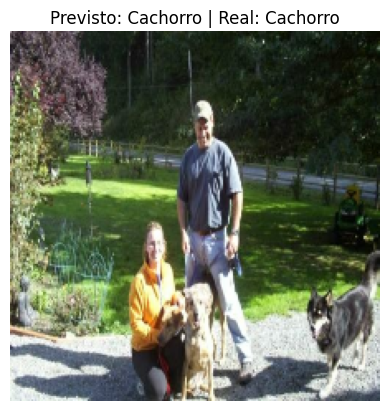

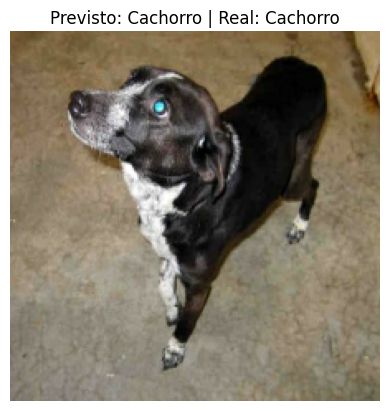

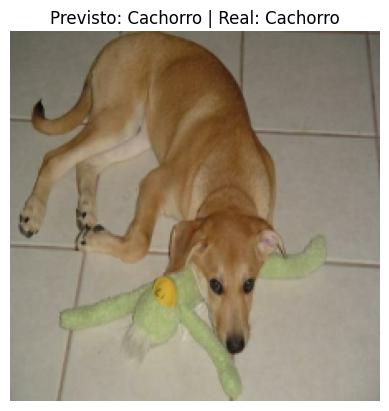

In [8]:
for images, labels in ds_test_prepared.take(1):
    predictions = model.predict(images)
    for i in range(5):
        plt.imshow(images[i].numpy())
        plt.title('Previsto: ' + ('Cachorro' if predictions[i][0] > 0.5 else 'Gato') +
                  ' | Real: ' + ('Cachorro' if labels[i].numpy() == 1 else 'Gato'))
        plt.axis('off')
        plt.show()